Things that happened training these animals:
- Changes on 26th March (lab meeting)
    - Added sucrose to water
    - Changed spouts and tubing link to avoid bubbles
    - Removed anti-bias

- Changes after stopping (from 25th of April)
    - Ports closer together

- Changes on 5th of May
    - New tasks states so that stimulus appears while holding in the center port

- Change on 16th of May
    - Punishment introduced to all mice

- 20th or 21st of May
    - Increase of waiting in center port to 0.5
- '2025-05-28 12:10:00'
    - LEDs ON
- '2025-06-10 14:00:00'
    - Removed timing restrictions for entering and staying doing the task
- 2025-06-20 to 22 there was an issue with port2 and overdetections. Discard this data for weight analysis. Actually,
    use it to see if they don't increase weight when they have ad libidum water. DONE
- 2025-07-02: Added the raspberri hat for the connections. Sound stopped working and we did not noticed until 2025-07-07.
    - Discard the data for auditory version, and monitor the relearning. The change was done from 11 am to 3pm or so.
- 2025-07-07: port2 was overdetecting again (unsure when this started). Fixed at 11am on the 8th.
- 2025-07-21: introduccion of mirrors.


Import libraries

In [1]:
import lecilab_behavior_analysis.utils as utils
import lecilab_behavior_analysis.df_transforms as dft
import lecilab_behavior_analysis.plots as plots
from pathlib import Path
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import time
from village.plots.corridor_plot import corridor_plot
import datetime


%load_ext autoreload
%autoreload 2

Retrieve data from the server

In [2]:
# see the available projects
tv_projects = utils.get_server_projects()
print(tv_projects)

['COT_test_data', 'visual_and_COT_data']


In [3]:
# select a project
project = tv_projects[1]
print(f"Selected project: {project}")

Selected project: visual_and_COT_data


In [4]:
# see the available animals
animals = utils.get_animals_in_project(project)
print(animals)

['ACV001', 'ACV002', 'ACV003', 'ACV004', 'ACV005', 'ACV006', 'ACV007', 'ACV008', 'ACV009', 'ACV010']


In [5]:
# optionally, remove some animals
animals_to_remove = ['test', 'test2']
animals = [animal for animal in animals if animal not in animals_to_remove]
print(animals)

['ACV001', 'ACV002', 'ACV003', 'ACV004', 'ACV005', 'ACV006', 'ACV007', 'ACV008', 'ACV009', 'ACV010']


generate a report for the project using the village code

In [6]:
# load events and sessions summary
local_path = Path(utils.get_outpath()) / Path(project)
# create the directory if it doesn't exist
local_path.mkdir(parents=True, exist_ok=True)
for file in ["old_events", "events.csv", "sessions_summary.csv"]:
    utils.rsync_cluster_data(
        project_name=project,
        file_path=file,
        local_path=str(local_path),
        credentials=utils.get_idibaps_cluster_credentials(),
    )

events_df = utils.load_all_events(project)
sessions_summary_df = pd.read_csv(local_path / Path("sessions_summary.csv"), sep=";")

receiving incremental file list
old_events/

sent 43 bytes  received 234 bytes  184.67 bytes/sec
total size is 12,879,798  speedup is 46,497.47
receiving incremental file list
events.csv

sent 8,935 bytes  received 61,085 bytes  28,008.00 bytes/sec
total size is 2,829,935  speedup is 40.42
receiving incremental file list
sessions_summary.csv

sent 16,351 bytes  received 2,628 bytes  7,591.60 bytes/sec
total size is 7,435,791  speedup is 391.79


In [7]:
# select the max date
# max_date = "2025-06-24"
max_date = datetime.datetime.now()

max_date = pd.to_datetime(max_date)

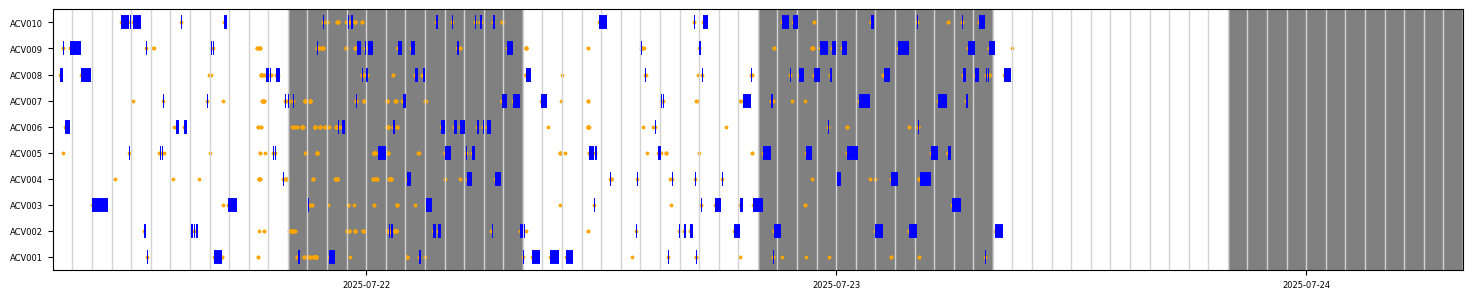

In [19]:
# make the corridor plot
cp = corridor_plot(
    df = events_df,
    subjects = animals,
    width = 15,
    height = 3,
    ndays = 4,
    from_date = max_date + pd.Timedelta(days=1),
)

In [17]:
# reduce the events_df and the session summary to the max_date
events_df = events_df[events_df['date'] <= max_date + pd.Timedelta(days=1)]
sessions_summary_df = sessions_summary_df[sessions_summary_df['date'] <= max_date + pd.Timedelta(days=1)]

In [ ]:
hours_back = 24  # hours to look back for the report
report_df, last_date = utils.generate_tv_report(events_df, sessions_summary_df, hours_back)

fig = plots.plot_table_from_df(report_df, title="TV Report - Last {} Hours until {}".format(hours_back, last_date))
fig.show()

In [20]:
# retrieve the data for the remaining animals
for mouse in animals:
    local_path = Path(utils.get_outpath()) / Path(project) / Path("sessions") / Path(mouse)
    # create the directory if it doesn't exist
    local_path.mkdir(parents=True, exist_ok=True)
    # download the session data
    utils.rsync_cluster_data(
        project_name=project,
        file_path="sessions/{}/{}.csv".format(mouse, mouse),
        local_path=str(local_path),
        credentials=utils.get_idibaps_cluster_credentials(),
    )
# Clear the output of the jupyter cell
clear_output(wait=True)
time.sleep(.5)
print("Data downloaded successfully.")

Data downloaded successfully.


Read the data

In [10]:
df_list = []
for mouse in animals:
    local_path = Path(utils.get_outpath()) / Path(project) / Path("sessions") / Path(mouse)
    df = pd.read_csv(local_path / Path(f'{mouse}.csv'), sep=";")
    df_list.append(df)
    print(f"Loaded data for {mouse}.")
# concatenate the dataframes
df = pd.concat(df_list, ignore_index=True)
clear_output(wait=True)
time.sleep(.5)
print("Data read successfully.")

Data read successfully.


In [11]:
# # create a profile report
# profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)
# # save the report to a file
# output_path = Path(utils.get_outpath()) / Path(tv_projects[1]) / Path("reports") / Path("profiling_report.html")
# output_path.parent.mkdir(parents=True, exist_ok=True)
# profile.to_file(output_file=str(output_path))
# # print the path to the report
# print(f"Profiling report saved to {output_path}.")

Fill missing values and add some columns

In [12]:
df = dft.analyze_df(df)
print("Dataframe analyzed.")

Dataframe analyzed.


In [23]:
df = df[df.subject.isin(["ACV001", "ACV002"])]

In [28]:
# Replace 'not saved' with 'Habituation'
df['current_training_stage'] = df['current_training_stage'].replace('not saved', 'Habituation')
# Get the order of training stages based on first appearance
training_stages_order = df['current_training_stage'].dropna().unique().tolist()
# Create pivot table
tr_stage_df = df.groupby(['subject', 'current_training_stage']).size().unstack(fill_value=0).reset_index()
# Reorder columns
tr_stage_df = tr_stage_df.reindex(columns=['subject'] + training_stages_order)
fig = plots.plot_table_from_df(tr_stage_df, title="Trials by Training Stage")
fig.show()

In [ ]:
# get the number of trials and performance of each animal for the past days
ndays = 3
df_nt_per = df.groupby(['subject', 'year_month_day']).agg(
    trials=('trial', 'count'),
    performance=('correct', 'mean')
).reset_index()
# make the performance only with three decimal points
df_nt_per['performance'] = df_nt_per['performance'].apply(lambda x: f"{x:.3f}")
# pivot to have the year_month_day as columns
df_nt_per = df_nt_per.pivot(index='subject', columns='year_month_day', values=['trials', 'performance'])
# select the last X days from the multilevel columns
df_nt_per_last = df_nt_per.loc[:, df_nt_per.columns.get_level_values(1).isin(df_nt_per.columns.levels[1][-ndays:])]
df_nt_per_last.reset_index(inplace=True)
# Render table adapting the multilevel columns
df_nt_per_last.columns = df_nt_per_last.columns.map(lambda x: f"{x[0]}_{x[1]}" if x[1] else x[0])
fig = plots.plot_table_from_df(df_nt_per_last, title="Trials and Performance by Subject and Date")
fig.show()

Occupancy of the box and mouse entries analysis

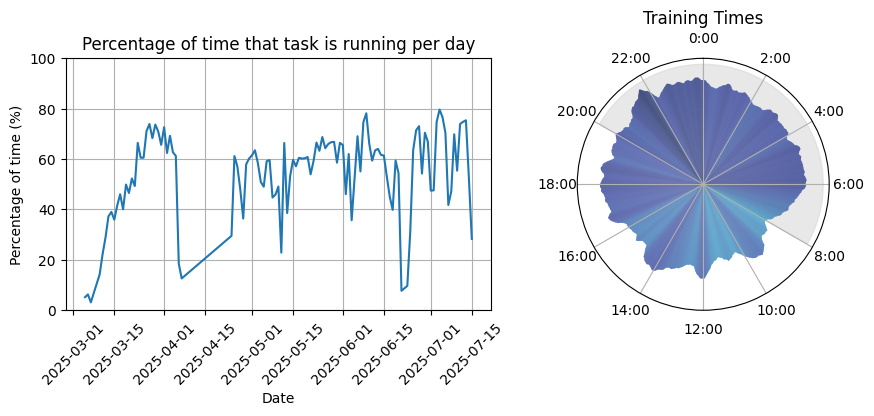

In [28]:
# Plot the percentage of time that the task is running per day and the heatmap of the occupancy during the day
occupancy_df = dft.get_start_and_end_of_sessions_df(df)
daily_percentages = dft.get_daily_occupancy_percentages(occupancy_df)
occupancy_heatmap = dft.get_occupancy_heatmap(occupancy_df, window_size=30)
fig, axs = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw={'width_ratios': [3, 2]})
# plot the percentage of occupancy per day
plots.plot_percentage_of_occupancy_per_day(daily_percentages, ax=axs[0])
# plot the heatmap of occupancy
# transform the second plot to a polar one like this subplot_kw={'projection': 'polar'}
fig.delaxes(axs[1])  # Remove the default second subplot
axs[1] = fig.add_subplot(1, 2, 2, projection='polar')  # Add a polar subplot
plots.plot_training_times_clock_heatmap(occupancy_heatmap, ax=axs[1])
plt.tight_layout()
plt.show()


Trials per day and evolution of performance

In [29]:
# plot the number of trials per day
df_to_plot = df.groupby(['subject', 'year_month_day', 'current_training_stage']).size().reset_index(name='trials')
# add also the correct percentage
df_to_plot_correct = df.groupby(['subject', 'year_month_day', 'current_training_stage'])[['correct', 'miss_trial']].mean().reset_index()
# merge the two dataframes
df_to_plot = df_to_plot.merge(df_to_plot_correct, on=['subject', 'year_month_day', 'current_training_stage'])
# sort the dataframe by date
df_to_plot = df_to_plot.sort_values(by=['year_month_day'])
# replace the current_training_stage values with more readable ones
df_to_plot['current_training_stage'] = df_to_plot['current_training_stage'].replace({
    'not saved': 'Habituation',
})

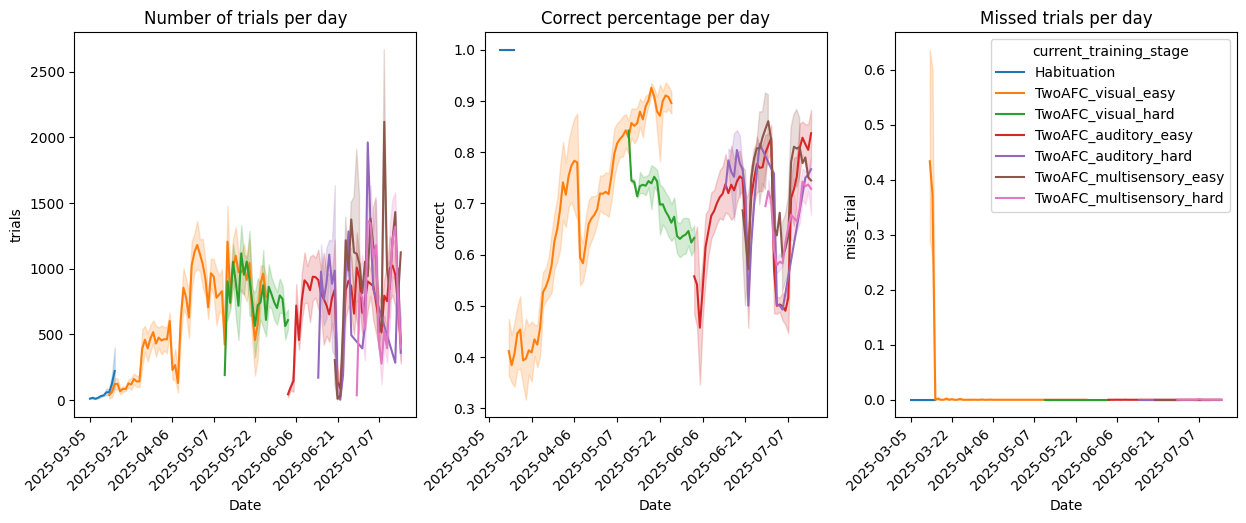

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs = axs.ravel()
sns.lineplot(data=df_to_plot, x='year_month_day', y='trials', hue='current_training_stage', ax=axs[0])
axs[0].set_title('Number of trials per day')
sns.lineplot(data=df_to_plot, x='year_month_day', y='correct', hue='current_training_stage', ax=axs[1])
axs[1].set_title('Correct percentage per day')
sns.lineplot(data=df_to_plot, x='year_month_day', y='miss_trial', hue='current_training_stage', ax=axs[2])
axs[2].set_title('Missed trials per day')
for ax in axs:
    ax.set_xlabel('Date')
    # tilt the x-axis labels and align them to the right
    ax.tick_params(axis='x', rotation=45)
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), ha='right')
    # show up to 10 ticks on the x-axis
    ax.xaxis.set_major_locator(plt.MaxNLocator(10))
# remove legends
for ax in axs[:-1]:
    ax.legend_.remove()

plt.show()

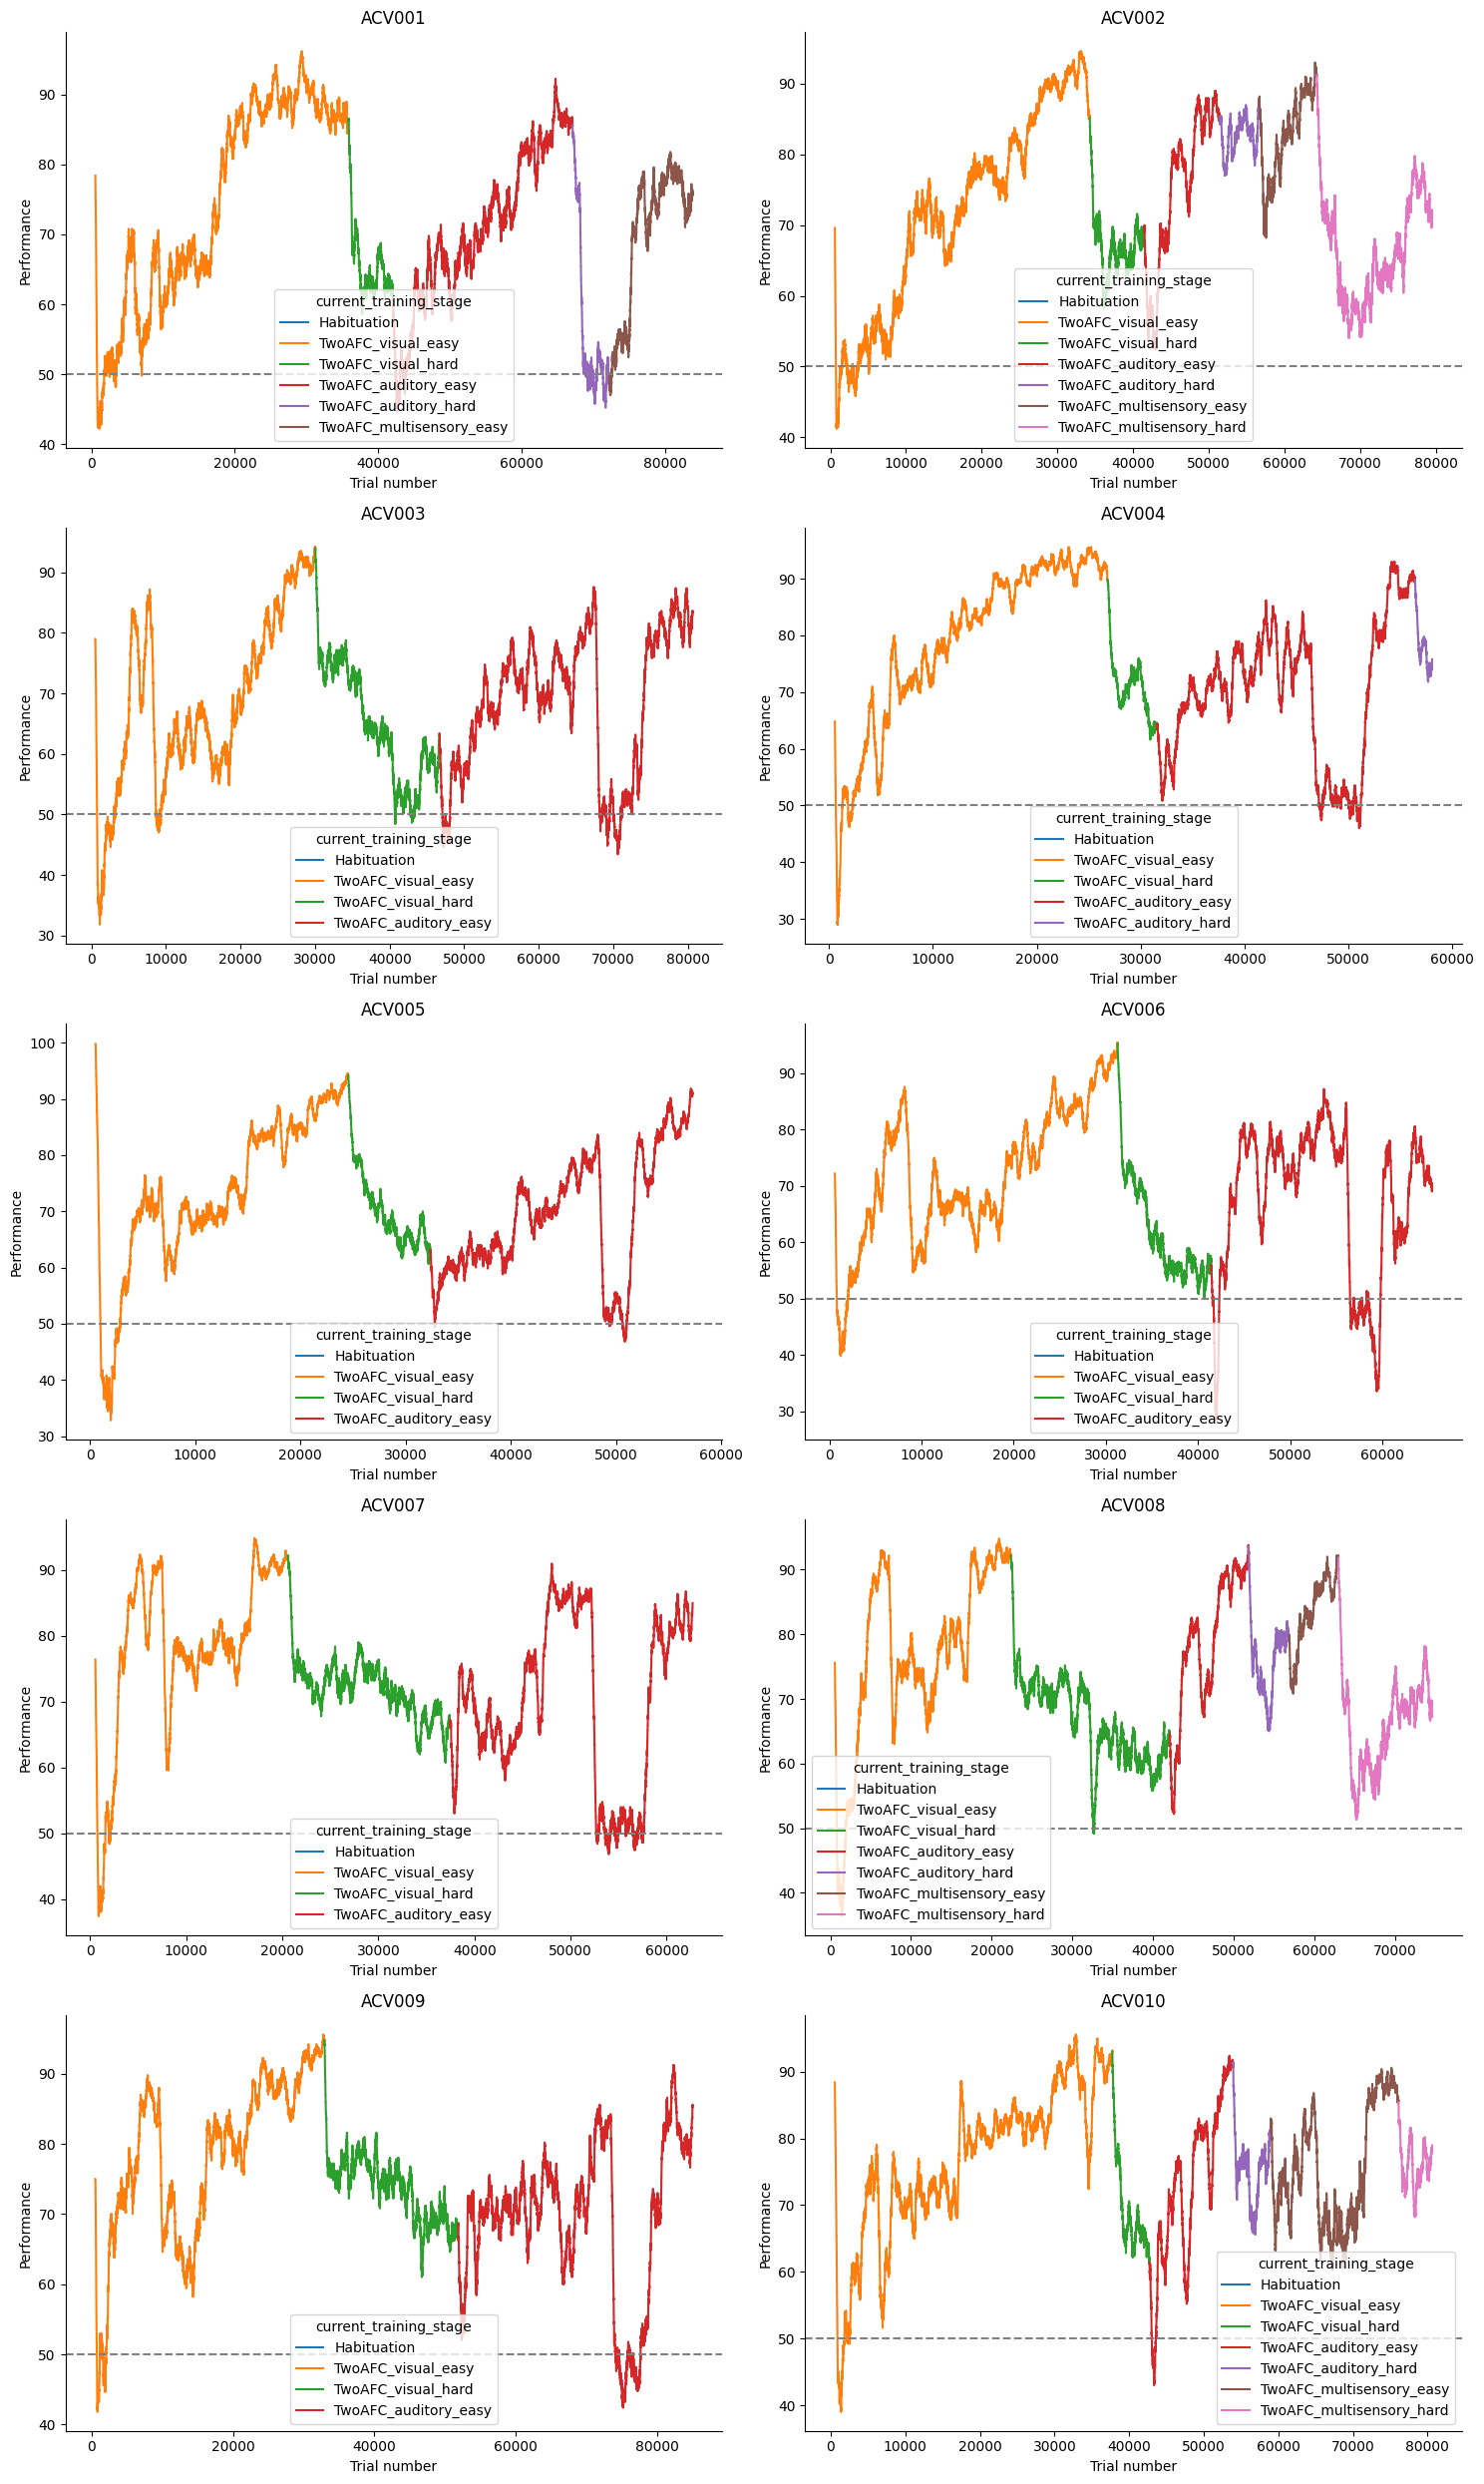

In [31]:
# plot the performance for each animal by training stage
ncols = 2
nrows = int(np.ceil(len(df.subject.unique()) / ncols))
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
axs = axs.ravel()
window = 500  # number of trials to consider for the performance calculation
for i, subject in enumerate(df.subject.unique()):
    ax_perf = axs[i]
    df_subj = df[df['subject'] == subject]
    # get the performance through trials
    df_subj = dft.get_performance_through_trials(df_subj, window=window)
    ax_perf = plots.performance_vs_trials_plot(df_subj, ax=ax_perf, legend=True)
    ax_perf.set_title(f"{subject}")
    ax_perf.set_xlabel('Trial number')
    ax_perf.set_ylabel('Performance')

# remove the empty subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])
plt.tight_layout()
plt.show()

In [65]:
# tests on the auditory behavior
aud_df = df[df.current_training_stage == 'TwoAFC_auditory_hard']
aud_df = dft.get_performance_by_difficulty_ratio(aud_df)


In [37]:
aud_df.tail()

,session,date,trial,subject,task,system_name,run_mode,Port1In,Port1Out,Port2In,...,total_trial,trial_of_day,number_of_tones_high,number_of_tones_low,total_percentage_of_tones_high,total_percentage_of_tones_low,percentage_of_timebins_with_evidence_high,percentage_of_timebins_with_evidence_low,total_evidence_strength,first_choice_numeric
705953,329.0,2025-06-27 08:07:44,195.0,ACV010,TwoAFC,village01,Auto,[1751009040.306977],[1751009040.5700772],"[1751009039.377377, 1751009040.8335772]",...,58944.0,195.0,33,7,0.220000,0.046667,0.64,0.24,0.650000,1
705954,329.0,2025-06-27 08:07:44,196.0,ACV010,TwoAFC,village01,Auto,"[1751009041.651857, 1751009043.040957]",[1751009041.7978568],[1751009042.1017568],...,58945.0,196.0,26,11,0.173333,0.073333,0.60,0.32,0.405405,1
705955,329.0,2025-06-27 08:07:44,197.0,ACV010,TwoAFC,village01,Auto,"[1751009046.130856, 1751009047.5217562]","[1751009044.5610561, 1751009046.379856, 175100...","[1751009044.8911562, 1751009046.6397562, 17510...",...,58946.0,197.0,0,68,0.000000,0.453333,0.00,0.96,-1.000000,1
705956,329.0,2025-06-27 08:07:44,198.0,ACV010,TwoAFC,village01,Auto,NaN,NaN,[1751009048.513776],...,58947.0,198.0,0,70,0.000000,0.466667,0.00,0.96,-1.000000,0
705957,329.0,2025-06-27 08:07:44,199.0,ACV010,TwoAFC,village01,Auto,[1751009051.760092],[1751009051.9305918],"[1751009050.973192, 1751009052.1807919, 175100...",...,58948.0,199.0,4,41,0.026667,0.273333,0.16,0.88,-0.822222,0


In [88]:
aud_df.col_test

67100     4.521789
67101    -3.583519
67102    -4.094345
67103    -3.784190
67104    -4.430817
            ...   
705953    3.332205
705954    2.995732
705955   -4.605170
705956   -4.605170
705957   -4.219508
Name: col_test, Length: 22011, dtype: float64

/home/hmv/Github/lecilab-behavior-analysis/lecilab_behavior_analysis/plots.py:334: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



<Axes: xlabel='col_test (binned)', ylabel='Leftward Choices'>

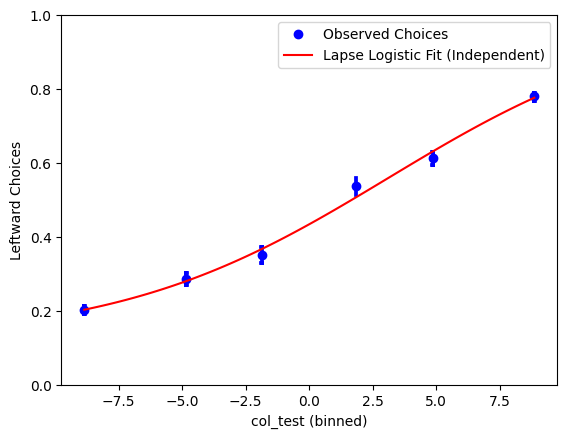

In [93]:
aud_df['col_test'] = aud_df['percentage_of_timebins_with_evidence_high'].apply(lambda x:(10 * (x - (1 - x))))
# apply a log respecting the sign of the value
# aud_df['col_test'] = aud_df['col_test'].apply(lambda x: np.log(x) if x > 0 else -np.log(-x))
# plot the psychometric
plots.psychometric_plot(
    df=aud_df,
    x='col_test',
    y='first_choice_numeric',
    valueType='continue',
    bins=6,
    )

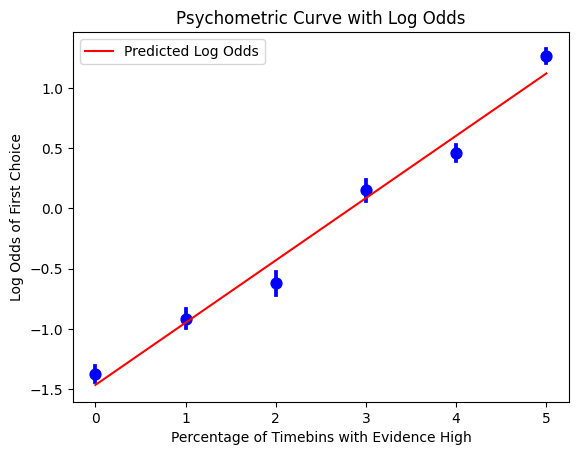

In [99]:
# bin the data by col_test
aud_df['col_test'] = pd.cut(aud_df['percentage_of_timebins_with_evidence_high'], bins=6, labels=False)

# Example plot with log-scaled y-axis
sns.pointplot(
    x='col_test',
    y='first_choice_numeric',
    data=aud_df,
    estimator=lambda x: np.log(np.mean(x) / (1 - np.mean(x))),  # Log odds transformation
    color='blue',
    markers='o',
    errorbar=("ci", 95),
    native_scale=True,
    linestyles='',
)

X = aud_df['col_test'].unique()
log_odds = []
for x in X:
    p = aud_df[aud_df['col_test'] == x]['first_choice_numeric'].mean()
    log_odds.append(np.log(p / (1 - p)))

# fit a simple line to the points
model = np.polyfit(X, log_odds, 1)
xs = np.linspace(aud_df['col_test'].min(), aud_df['col_test'].max(), 100).reshape(-1, 1)
predicted_log_odds = model[0] * xs + model[1]

plt.plot(xs, predicted_log_odds, color='red', label='Predicted Log Odds')
plt.legend()

plt.xlabel("Percentage of Timebins with Evidence High")
plt.ylabel("Log Odds of First Choice")
plt.title("Psychometric Curve with Log Odds")

plt.show()

In [ ]:
# first test on multisensory
df_sub = df[df['current_training_stage'] == "TwoAFC_multisensory_easy"]
df_sub.groupby(['subject', 'stimulus_modality']).agg(
    performance=('correct', 'mean'),
    trials=('trial', 'count')
)

performance  trials
subject stimulus_modality                    
ACV001  auditory             0.502774    1442
        visual                0.58309    1372
ACV002  auditory              0.89899    3960
        visual               0.751017    3687
ACV008  auditory             0.884443    2899
        visual               0.802005    3192
ACV010  auditory             0.658388    5758
        visual               0.759131    6626

In [13]:
# plot what the animal is doing, if it is alternating or repeating to the left or to the right
# NOTE: This is not the same as the next analysis, as this is what the animal is doing, not what it should do
df = dft.add_port_where_animal_comes_from(df)
# get a metric to see the bias in choices (including alternation)
df['roa_choice_numeric'] = df.apply(utils.get_repeat_or_alternate_to_numeric, axis=1)

/home/hmv/Github/lecilab-behavior-analysis/lecilab_behavior_analysis/df_transforms.py:122: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan nan nan 'left' 'right' 'right' 'right' 'left' 'left' 'right' 'right']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.



In [26]:
# Convert columns to numeric, coercing errors to NaN
previous_last_choice = df['last_choice'].shift(1).replace({'left': 1, 'right': 0, 'none': np.nan})
previous_port_before_stimulus = df['previous_port_before_stimulus'].replace({'left': 1, 'right': 0, 'none': np.nan})

# Drop rows with NaN values
valid_rows = previous_last_choice.notna() & previous_port_before_stimulus.notna()
previous_last_choice = previous_last_choice[valid_rows]
previous_port_before_stimulus = previous_port_before_stimulus[valid_rows]

# Calculate the correlation coefficient
np.corrcoef(previous_port_before_stimulus, previous_last_choice)

/tmp/ipykernel_493577/588578857.py:2: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`

/tmp/ipykernel_493577/588578857.py:3: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



array([[1.       , 0.8276577],
       [0.8276577, 1.       ]])

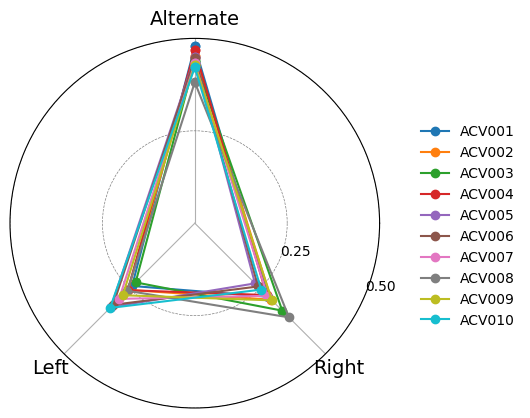

In [ ]:
# create a polar plot to see the general bias
df_triangle_polar = dft.get_triangle_polar_plot_df(df)
# plot the polar plot
fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
ax = plots.triangle_polar_plot(df_triangle_polar, ax=ax)
plt.show()

In [ ]:
# show the triangles above per animal fluctuating per X number of trials with different hue,
# and illustrating the before and after moving the ports closer
date_of_moving_ports = pd.to_datetime('2025-04-20')
df_before_after = df.copy()
# add a column to indicate if the animal is before or after the moving ports
df_before_after['before_after'] = pd.to_datetime(df_before_after.year_month_day).apply(lambda x: 'before' if x < date_of_moving_ports else 'after')
# recalculate the trial number
df_before_after['total_trial_ba'] = df_before_after.groupby(['subject', 'before_after']).cumcount() + 1
trial_group_size = 200
df_before_after['trial_group'] = df_before_after['total_trial'] // trial_group_size * trial_group_size
groupby = ["trial_group", "before_after"]
df_bias_evolution = dft.get_bias_evolution_df(df_before_after, groupby=groupby)

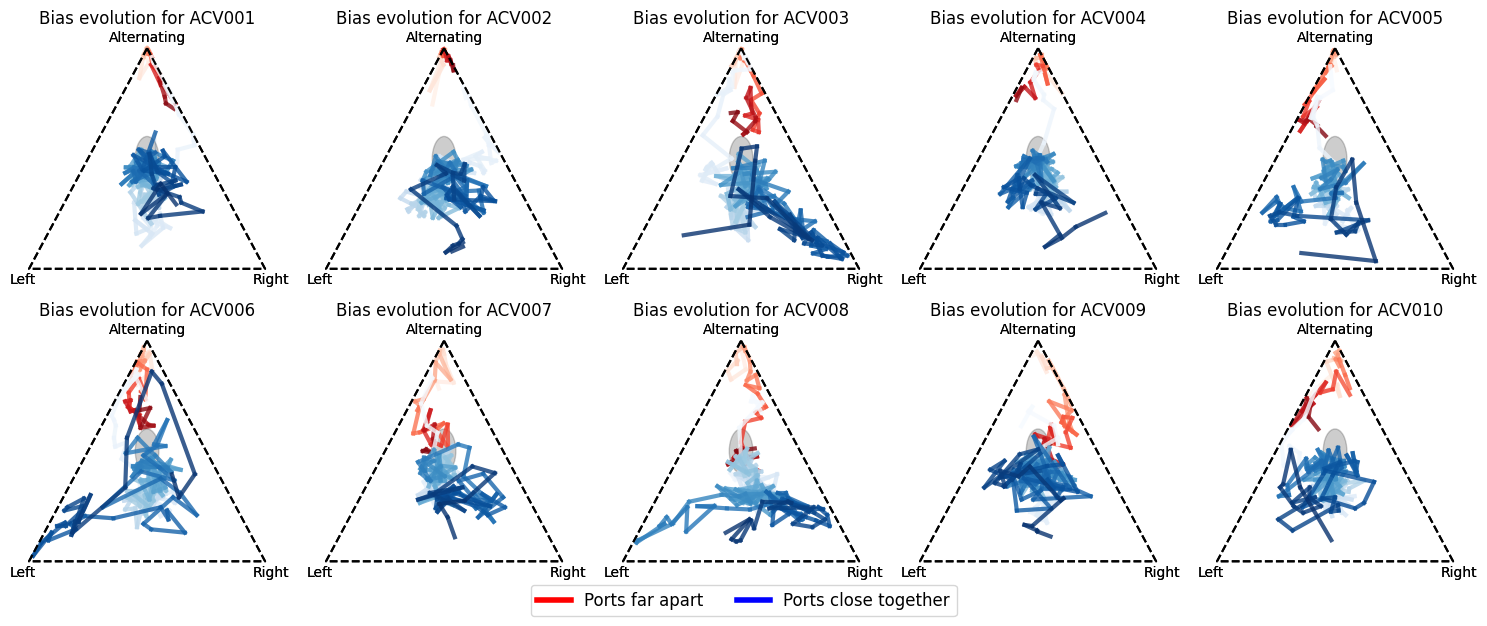

In [ ]:
# plot the bias trajectories
total_subjects = df_bias_evolution['subject'].nunique()
ncols = 5
nrows = int(np.ceil(total_subjects / ncols))
fig, axs = plt.subplots(nrows, ncols, figsize=(15, 3 * nrows), sharey=True)
for subject, ax in zip(df_bias_evolution['subject'].unique(), axs.ravel()):
    df_sub = df_bias_evolution[df_bias_evolution['subject'] == subject]
    for bef_or_after in df_sub['before_after'].unique():
        df_sub_ba = df_sub[df_sub['before_after'] == bef_or_after]
        df_sub_ba = dft.points_to_lines_for_bias_evolution(df_sub_ba, groupby="trial_group")
        # define a palette depending if it is before or after
        if bef_or_after == 'before':
            palette = sns.color_palette("Reds", n_colors=len(df_sub_ba['trial_group'].unique()))
        else:
            palette = sns.color_palette("Blues", n_colors=len(df_sub_ba['trial_group'].unique()))
        ax = plots.plot_decision_evolution_triangle(df_sub_ba, ax=ax, hue="trial_group", palette=palette)
    ax.set_title(f'Bias evolution for {subject}', pad=10, fontsize=12)
# create a legend for the before and after at the bottom of the figure
handles = [plt.Line2D([0], [0], color='red', lw=4, label='Ports far apart'),
           plt.Line2D([0], [0], color='blue', lw=4, label='Ports close together')]
fig.legend(handles=handles, loc='lower center', ncol=2, fontsize=12, bbox_to_anchor=(0.5, -0.05))
plt.tight_layout()
plt.show()

Analysis of the 2AFC task

In [14]:
# Correct percentage per total trial in 2AFC. Separate also alternating and repeating
# add also the time start of each trial with respect to the start of the session
df2afc = df[df['current_training_stage'] == 'TwoAFC_auditory_easy']
# First, get a column that indicates what the animal should do
df_subject_list = []
for mouse in animals:
    df_mouse = df2afc[df2afc['subject'] == mouse]
    df_session_list = []
    for session in df_mouse['session'].unique():
        df_session = df_mouse[df_mouse['session'] == session].copy()
        df_session["repeat_or_alternate"] = dft.get_repeat_or_alternate_series(df_session.correct_side)
        session_start_time = df_session['TRIAL_START'].iloc[0]
        df_session['time_from_start'] = df_session['TRIAL_START'] - session_start_time
        df_session_list.append(df_session)
    # calculate the performances
    df_mouse = pd.concat(df_session_list, ignore_index=True)
    df_mouse = dft.get_repeat_or_alternate_performance(df_mouse, window=25)
    df_mouse = dft.get_performance_through_trials(df_mouse, window=25)
    df_subject_list.append(df_mouse)

df2afc = pd.concat(df_subject_list, ignore_index=True)

In [15]:
# Create a new column with the trials in this training stage
df2afc['total_trial_2afc'] = df2afc.groupby('subject').cumcount() + 1

In [16]:
# Plot the performance through trials
# Bin the total trials every 100 trials
df2afc['total_trial_bin'] = df2afc['total_trial_2afc'] // 100 * 100
# Group by the binned total trials and calculate the mean performance
df_perf_binned = df2afc.groupby(['subject', 'total_trial_bin', 'repeat_or_alternate']).agg({'correct': 'mean'}).reset_index()

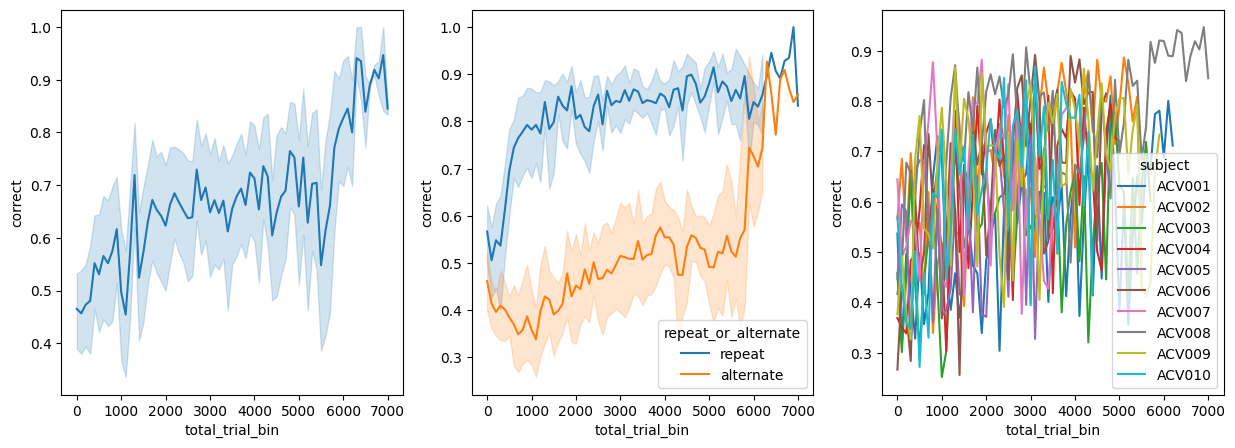

In [17]:
# plot the performance through trials
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))
# plot the performance through trials
sns.lineplot(data=df_perf_binned, x='total_trial_bin', y='correct', ax=axs[0])
sns.lineplot(data=df_perf_binned, x='total_trial_bin', y='correct', hue='repeat_or_alternate', hue_order=['repeat', 'alternate'], ax=axs[1])
sns.lineplot(data=df_perf_binned, x='total_trial_bin', y='correct', hue='subject', ax=axs[2], errorbar=None)
plt.show()

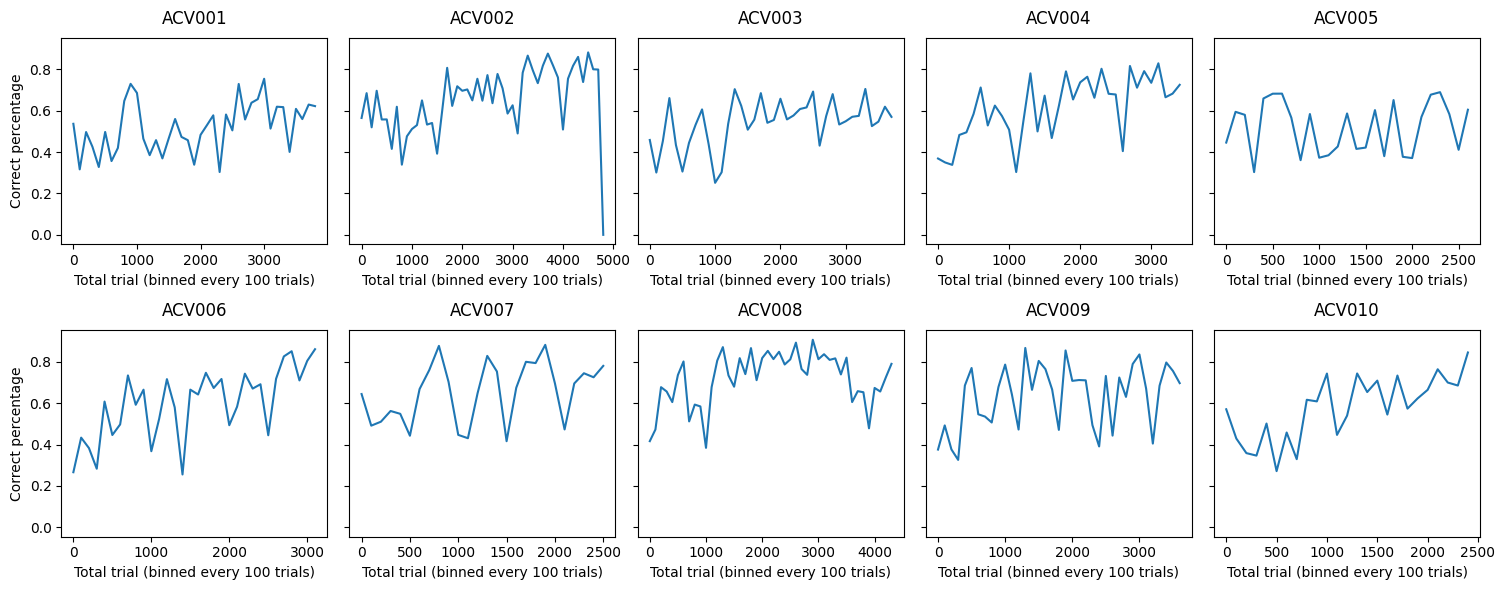

In [29]:
# show one plot per animal
fig, axs = plt.subplots(nrows, ncols, figsize=(15, 3 * nrows), sharey=True)
for subject, ax in zip(df_perf_binned['subject'].unique(), axs.ravel()):
    df_sub = df_perf_binned[df_perf_binned['subject'] == subject]
    sns.lineplot(data=df_sub, x='total_trial_bin', y='correct', ax=ax, errorbar=None)
    ax.set_title(f'{subject}', pad=10, fontsize=12)
    ax.set_xlabel('Total trial (binned every 100 trials)')
    ax.set_ylabel('Correct percentage')
plt.tight_layout()

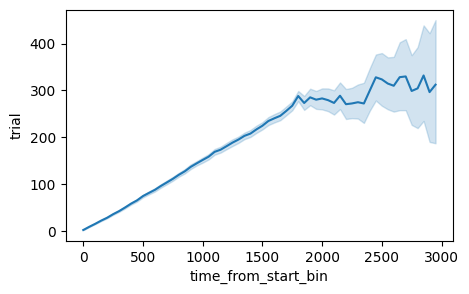

In [24]:
# show the cumulative trials per moment of each session
df2afc["time_from_start_bin"] = df2afc["time_from_start"] // 50 * 50
df2afc_cumulative = df2afc.groupby(["time_from_start_bin", "date"])["trial"].max().reset_index()
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5, 3))
sns.lineplot(data=df2afc_cumulative, x='time_from_start_bin', y='trial', ax=axs)
plt.show()

Animals do not work for more than 28 minutes

In [25]:
#TODO: calculate reaction times per animal in 2AFC and show overlapping distributions
#TODO: show evolution of the reaction times per day, and the iti
#TODO: plot the waiting time in the middle and the number of times they leave the port earlier
#TODO: do this analysis for the postdoc data and compare

Look into behavior more closely

In [26]:
# select only one mouse for now
df2afc_sel = df2afc[df2afc['subject'] == 'ACV001']

In [27]:
# # select those sessions with performance above 0.65
# sessions_to_keep = df2afc_sel.groupby('session')['correct'].mean().reset_index()
# sessions_to_keep = sessions_to_keep[sessions_to_keep['correct'] > 0.55]['session'].unique()
# # filter the dataframe to keep only those sessions
# df2afc_sel = df2afc_sel[df2afc_sel['session'].isin(sessions_to_keep)]

In [28]:
# alternatively, group trials in chunks of 500 trials
trial_group_size = 500
df2afc_sel = df2afc_sel.copy() # avoids a stupid warning
df2afc_sel['trial_group'] = df2afc_sel['total_trial'] // trial_group_size * trial_group_size

In [29]:
df2afc_sel = dft.add_visual_stimulus_difference(df2afc_sel)

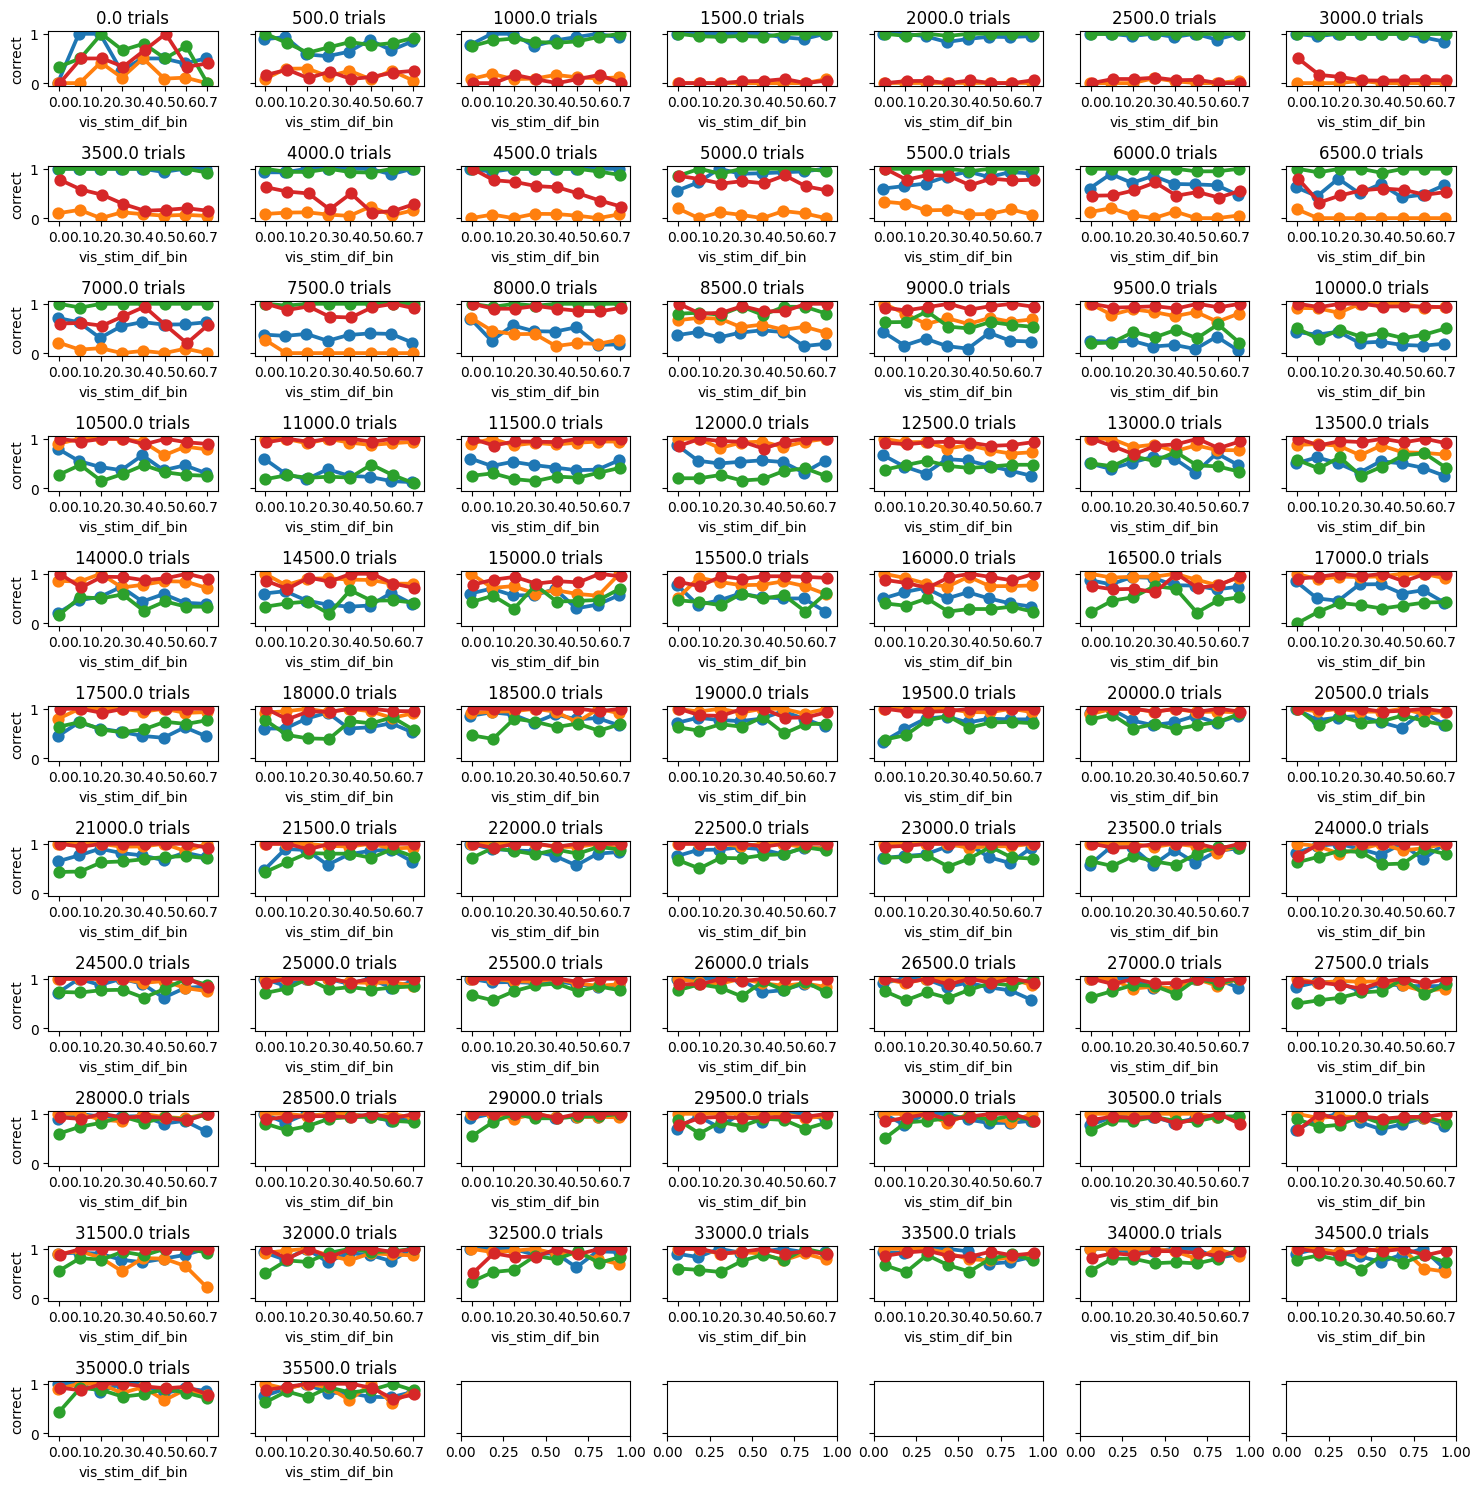

In [30]:
# TODO: compare this with the condition of where the animal comes from

# check the evolution of each of these "decisions" during training
# group by the binned data and calculate the mean performance
df2afc_binned = df2afc_sel.groupby(['vis_stim_dif_bin', 'correct_side', 'repeat_or_alternate', 'trial_group'])[['correct']].mean().reset_index()
# get the different combinations of correct side and repeat or alternate
df2afc_binned['correct_side_repeat_or_alternate'] = df2afc_binned['correct_side'] + '_' + df2afc_binned['repeat_or_alternate']
# get only the 4 combinations and remove nans etc
df2afc_binned = df2afc_binned[df2afc_binned['correct_side_repeat_or_alternate'].isin(['left_repeat', 'left_alternate', 'right_repeat', 'right_alternate'])]


# plot the binned data with the new combination for each day
ncols = 7
nrows = pd.unique(df2afc_binned['trial_group']).size // ncols + 1
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15, 15), sharey=True)
axs = axs.ravel()
# plot the binned data for each trial group
for (trial_group, group), ax in zip(df2afc_binned.groupby('trial_group'), axs):
    try:
        sns.pointplot(data=group, x='vis_stim_dif_bin', y='correct', hue='correct_side_repeat_or_alternate', dodge=True, errorbar=None, ax=ax, legend=False)
    except ZeroDivisionError:
        # If there's a ValueError, it might be due to not enough data points for the hue
        # In this case, we can skip plotting for this group
        # print(f"Skipping {day} due to insufficient data for plotting.")
        continue
    ax.set_title(f'{trial_group} trials', fontsize=12)
plt.tight_layout()
plt.show()

this shows that when they are learning and they struggle with a decision kind, they use the overall intensity of the port to take that decision. But it is not a general side bias, as it does not affect the alternation behavior

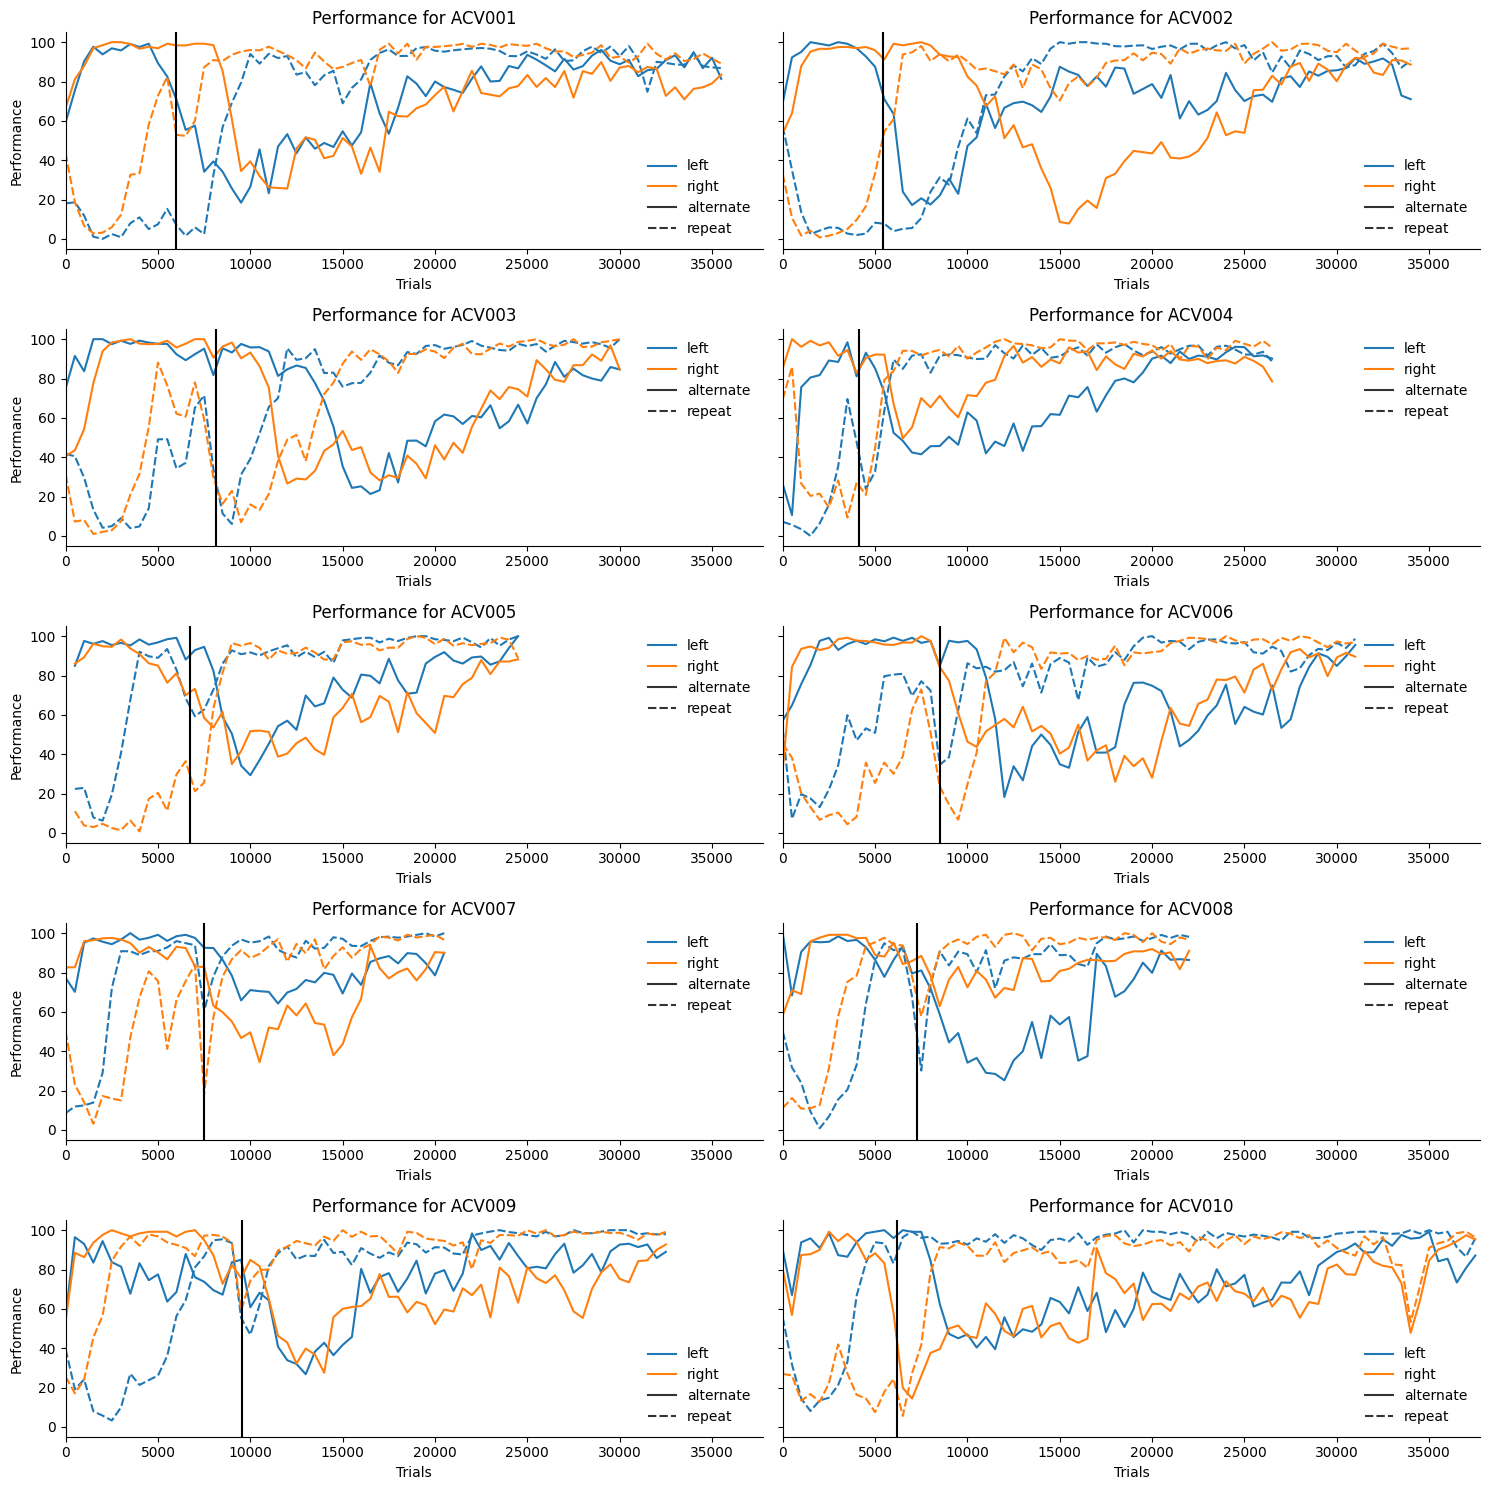

In [31]:
# show this analysis for all the mice
total_subjects = df2afc['subject'].nunique()
ncols = 2
nrows = int(np.ceil(total_subjects / ncols))
# find the max trials that a subject has done
max_trials = df2afc['total_trial'].max()
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(15, 3 * nrows), sharey=True)
for subject, ax in zip(df2afc['subject'].unique(), axs.ravel()):
    # filter the dataframe to keep only the current subject
    df_subject = df2afc[df2afc['subject'] == subject]
        # group by the binned data and calculate the mean performance
    df_pbd = dft.get_performance_by_decision_df(df_subject)
    # plot the data
    plots.performance_by_decision_plot(df_pbd, ax=ax)
    ax.set_title(f'Performance for {subject}')
    ax.set_xlim(0, max_trials)
    # plot a vertical line between before and after the moving ports
    # generate a vector that shows when df_subject.before_after changes
    ch_vec = df_subject['before_after'].ne(df_subject['before_after'].shift()).astype(int)
    ch_vec.iloc[0] = 0
    # get the indices of the changes
    ch_indices = np.where(ch_vec == 1)[0][0]
    # plot a vertical line at the first change
    ax.axvline(x=df_subject['total_trial'].iloc[ch_indices], color='black', linestyle='-')

plt.tight_layout()
plt.show()

each mouse has a prefered side, but they all have to counteract the "alternation" strategy, although they do this without affecting the performance on the alternation. Moving the ports closer changes the overall strategy but animals keep a preferred side

In [29]:

import altair as alt
import pandas as pd

# Sample data (replace with your actual dataset)
data = df_to_plot.copy()
# convert nans to 1
data['correct'] = data['correct'].fillna(1) * 100

/tmp/ipykernel_31238/4255951163.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['correct'] = data['correct'].fillna(1) * 100


In [30]:
import altair as alt
import pandas as pd
import numpy as np

# Convert date to datetime format
data['year_month_day'] = pd.to_datetime(data['year_month_day'])

# Get min and max dates
min_date = data['year_month_day'].min()
max_date = data['year_month_day'].max()

# Create a list of all dates in the range
date_range = pd.date_range(start=min_date, end=max_date)
date_strings = [d.strftime('%Y-%m-%d') for d in date_range]

# Add a numeric field for the slider
data['date_index'] = data['year_month_day'].apply(
    lambda x: np.where(date_range == x)[0][0]
)

# Find global min and max values for x and y axes
min_trials = data['trials'].min()
max_trials = data['trials'].max()
min_correct = data['correct'].min()
max_correct = data['correct'].max()

# Add some padding to the axis limits (10%)
trials_padding = (max_trials - min_trials) * 0.1
correct_padding = (max_correct - min_correct) * 0.1

# Create a slider for date selection
date_slider = alt.binding_range(
    min=0,
    max=len(date_range)-1,
    step=1,
    name='Date: '
)

# Create a parameter that updates with the slider
date_selection = alt.param(
    name='date_idx',
    value=0,
    bind=date_slider
)

# Create a derived field for display purposes
slider_date = alt.expr.time(date_range[0].timestamp()*1000) + alt.expr.milliseconds(86400000 * date_selection)

# Hover selection for subjects
hover_selection = alt.selection_point(
    name='hover',
    on='mouseover', 
    fields=['subject'],
    empty=False
)

# Base chart encoding
base_encoding = dict(
    x=alt.X('trials:Q', 
            title='Number of Trials',
            scale=alt.Scale(domain=[min_trials - trials_padding, max_trials + trials_padding])),
    y=alt.Y('correct:Q', 
            title='Correct Choices (%)', 
            scale=alt.Scale(domain=[0, 100])),
    color=alt.Color('current_training_stage:N', 
                    title='Training Stage',
                    legend=alt.Legend(orient='bottom', 
                                      titleFontSize=12, 
                                      labelFontSize=10))
)

# Main points filtered by current date
points = alt.Chart(data).mark_circle().encode(
    **base_encoding,
    size=alt.Size('trials:Q', title='Trials', scale=alt.Scale(range=[10, 200])),
    opacity=alt.condition(hover_selection, alt.value(1), alt.value(0.5)),
    tooltip=['subject', 'trials', 'correct', 'current_training_stage', 
             alt.Tooltip('year_month_day:T', title='Date')]
).transform_filter(
    alt.datum.date_index == date_selection
).add_params(hover_selection)

# Trajectories that appear on hover
trajectories = alt.Chart(data).mark_line(
    opacity=0.7,
    strokeWidth=2
).encode(
    **base_encoding,
    detail='subject:N',
    opacity=alt.condition(hover_selection, alt.value(0.8), alt.value(0))
).transform_filter(
    hover_selection
)

# All points for the selected subject (trajectory points)
trajectory_points = alt.Chart(data).mark_circle(
    size=80
).encode(
    **base_encoding,
    opacity=alt.condition(hover_selection, alt.value(0.8), alt.value(0)),
    tooltip=['subject', 'trials', 'correct', 'current_training_stage', 
             alt.Tooltip('year_month_day:T', title='Date')]
).transform_filter(
    hover_selection
)

# Date labels for trajectory points
date_labels = alt.Chart(data).mark_text(
    align='left',
    baseline='middle',
    dx=10,
    fontSize=10
).encode(
    **base_encoding,
    text='year_month_day:T',
    opacity=alt.condition(hover_selection, alt.value(1), alt.value(0))
).transform_filter(
    hover_selection
)

# Subject labels that appear on hover
subject_labels = alt.Chart(data).mark_text(
    align='center',
    baseline='bottom',
    dy=-10,
    fontSize=14,
    fontWeight='bold'
).encode(
    **base_encoding,
    text='subject:N',
    opacity=alt.condition(hover_selection, alt.value(1), alt.value(0))
).transform_filter(
    alt.datum.date_index == date_selection
).transform_filter(
    hover_selection
)

# Current date display
date_display = alt.Chart({'values': [{}]}).mark_text(
    align='right',
    baseline='top',
    fontSize=14,
    font='Arial',
    fontWeight='bold',
    dx=-10,
    dy=10
).encode(
    text=alt.Text(
        'yearmonthdate(datum.date):T',
        title='Current Date'
    ),
    x=alt.value(600),  # Right side of the chart
    y=alt.value(0)     # Top of the chart
).transform_calculate(
    date=slider_date
)

# Combine all layers
chart = alt.layer(
    points, 
    trajectories, 
    trajectory_points, 
    date_labels, 
    subject_labels, 
    date_display
).properties(
    width=600, 
    height=400,
    title='Subject Performance by Date'
).add_params(date_selection)

chart

alt.LayerChart(...)

In [31]:
data['year_month_day']

0     2025-03-05
172   2025-03-05
227   2025-03-05
280   2025-03-05
58    2025-03-05
         ...    
450   2025-05-19
279   2025-05-19
57    2025-05-19
508   2025-05-19
564   2025-05-19
Name: year_month_day, Length: 565, dtype: datetime64[ns]

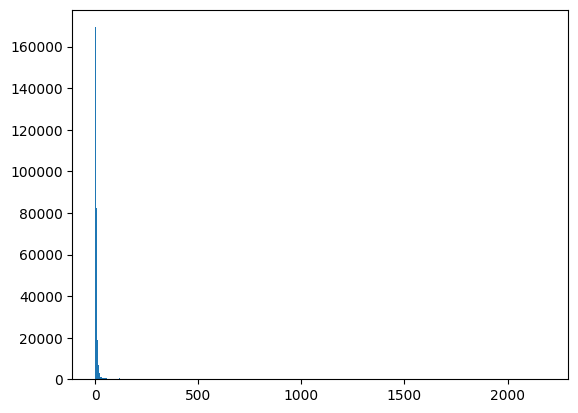

In [32]:
plt.hist(df.TRIAL_END - df.TRIAL_START, bins=500)
plt.show()

In [33]:
df.columns

Index(['session', 'date', 'trial', 'subject', 'task', 'system_name',
       'run_mode', 'Port1In', 'Port1Out', 'Port2In', 'Port2Out', 'Port3In',
       'Port3Out', 'STATE_auto_reward_state_left_END',
       'STATE_auto_reward_state_left_START', 'STATE_hold_center_port_END',
       'STATE_hold_center_port_START', 'STATE_hold_while_stimulus_END',
       'STATE_hold_while_stimulus_START', 'STATE_iti_END', 'STATE_iti_START',
       'STATE_punish_state_END', 'STATE_punish_state_START',
       'STATE_ready_to_initiate_END', 'STATE_ready_to_initiate_START',
       'STATE_reward_state_END', 'STATE_reward_state_START',
       'STATE_reward_state_left_END', 'STATE_reward_state_left_START',
       'STATE_reward_state_right_END', 'STATE_reward_state_right_START',
       'STATE_start_of_trial_END', 'STATE_start_of_trial_START',
       'STATE_stimulus_state_END', 'STATE_stimulus_state_START', 'TRIAL_END',
       'TRIAL_START', 'Tup', 'auditory_stimulus', 'correct', 'correct_side',
       'current_tr